In [1]:
import json
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from networkx.algorithms import bipartite
from collections import Counter
import itertools

## Follower

In [2]:
followersNetwork = nx.DiGraph()

In [3]:
followerGraph = nx.read_edgelist( "business/friendships.csv" , delimiter = "\t", create_using=followersNetwork)
followerGraph.number_of_nodes(), followerGraph.number_of_edges()

(32, 300)

In [4]:
#created a function to make the network graphs 
def makeGraph(graph, col, title):
    plt.figure(figsize=(15,15))
    title = title 
    plt.title(title, fontsize=14)
    plt.margins(0.01, 0.001)
    pos = nx.spring_layout(graph)
    nx.draw_networkx(graph, pos, with_labels=True, font_size=8, node_size=200, node_color=col, edge_color="lightblue")
    plt.show() 

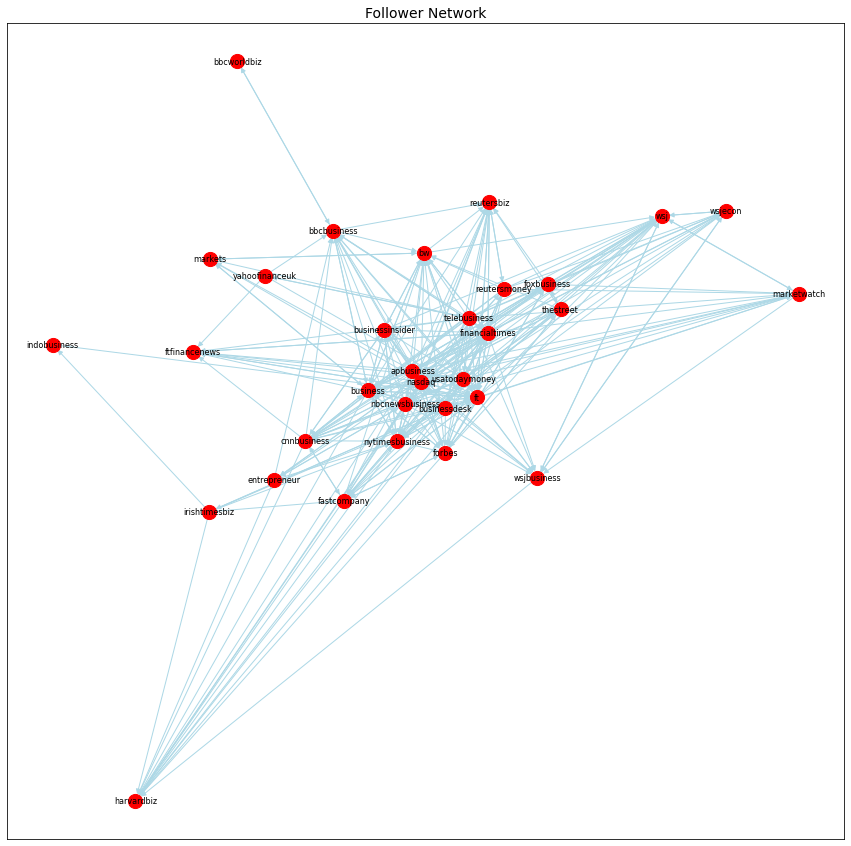

In [5]:
makeGraph(followerGraph, "red", "Follower Network")

## Reply

In [6]:
replyNetwork = nx.DiGraph()

In [7]:
file = open( "business/tweets.jsonl", "r" )
tweets = []
# process the file line-by-line
for line in file.readlines():
    line = line.strip()
    # each line contains a JSON document, representing a single tweet
    tweet = json.loads(line)
    tweets.append(tweet)
file.close()
print("Read %d tweets" % len(tweets))

Read 16000 tweets


In [8]:
networkGraph = pd.DataFrame(tweets).set_index("id")

In [9]:
columns = ['id_str','created_at', 'truncated', 'display_text_range', 'favorited', 'retweeted','possibly_sensitive', 
           'lang', 'extended_entities', 'retweeted_status', 'quoted_status_id','quoted_status_id_str',
          'quoted_status_permalink', 'quoted_status', 'geo','coordinates','contributors','is_quote_status','retweet_count', 'favorite_count','place']

In [10]:
networkGraph = networkGraph.drop(columns, axis=1)

In [11]:
networkGraph["user"][1352679491966033922]

{'id': 3108351,
 'id_str': '3108351',
 'name': 'The Wall Street Journal',
 'screen_name': 'WSJ',
 'location': 'New York, NY',
 'description': 'Sign up for our newsletters and email alerts: https://t.co/WFU7oLKkip',
 'url': 'https://t.co/GhhR6PLfem',
 'entities': {'url': {'urls': [{'url': 'https://t.co/GhhR6PLfem',
     'expanded_url': 'http://wsj.com',
     'display_url': 'wsj.com',
     'indices': [0, 23]}]},
  'description': {'urls': [{'url': 'https://t.co/WFU7oLKkip',
     'expanded_url': 'http://wsj.com/newsletters',
     'display_url': 'wsj.com/newsletters',
     'indices': [46, 69]}]}},
 'protected': False,
 'followers_count': 18452260,
 'friends_count': 1003,
 'listed_count': 118425,
 'created_at': 'Sun Apr 01 06:22:13 +0000 2007',
 'favourites_count': 1181,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': True,
 'verified': True,
 'statuses_count': 329696,
 'lang': None,
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': True,
 'profile_

In [12]:
users = [] 
users=pd.json_normalize(networkGraph["user"])

In [13]:
columnsNeeded = ['id','screen_name']

In [14]:
users.drop(users.columns.difference(columnsNeeded), 1, inplace=True)

In [15]:
replyGraph = pd.concat([networkGraph.reset_index(drop=True),users.reset_index(drop=True)], axis=1)

In [16]:
replyGraph = replyGraph[replyGraph['in_reply_to_screen_name'].notna()]

In [17]:
columnsNeeded = ['screen_name','in_reply_to_screen_name']

In [18]:
replyGraph.drop(replyGraph.columns.difference(columnsNeeded), 1, inplace=True)

In [19]:
for i,row in replyGraph.iterrows():
        replyNetwork.add_node(row["in_reply_to_screen_name"])

In [20]:
for i,rows in replyGraph.iterrows():
    if rows['screen_name'] != rows['in_reply_to_screen_name']:
        replyNetwork.add_edge( rows["screen_name"], rows["in_reply_to_screen_name"]) 

In [21]:
replyNetwork.number_of_nodes(), replyNetwork.number_of_edges()

(69, 49)

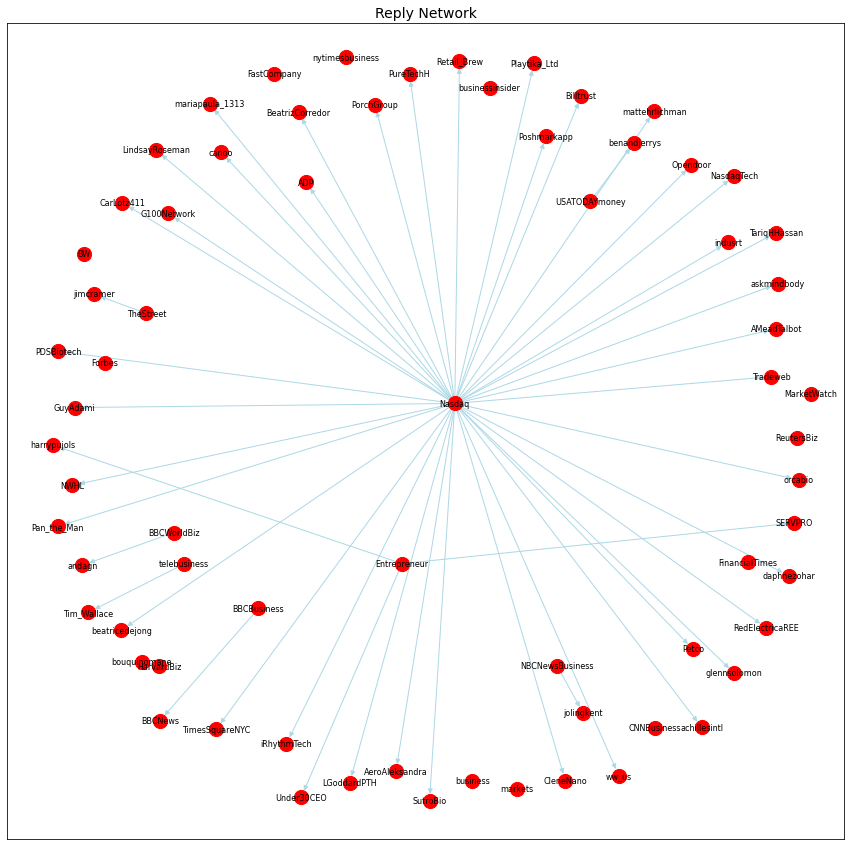

In [22]:
makeGraph(replyNetwork, "red", "Reply Network")

## Mention

In [23]:
mentionNetwork = nx.DiGraph()

In [24]:
mentions = [] 
mentions = pd.json_normalize(networkGraph["entities"])

In [25]:
mentions.head(2)

,hashtags,symbols,user_mentions,urls,media
0,[],[],[],"[{'url': 'https://t.co/HyEGHcXnep', 'expanded_...",NaN
1,[],[],[],"[{'url': 'https://t.co/k8MUYjKu8G', 'expanded_...",NaN


In [26]:
columnsNeeded = ['user_mentions']

In [27]:
mentions.drop(mentions.columns.difference(columnsNeeded), 1, inplace=True)

In [28]:
mentionGraph = pd.concat([users.reset_index(drop=True),mentions.reset_index(drop=True)], axis=1)

In [29]:
mentionGraph = mentionGraph[mentionGraph['user_mentions'].map(lambda drop: len(drop)) > 0]
mentionGraph

,id,screen_name,user_mentions
14,2252205206,BBCWorldBiz,"[{'screen_name': 'robyounguk', 'name': 'Rob Yo..."
16,16737418,IrishTimesBiz,"[{'screen_name': 'IrishTimesBiz', 'name': 'Iri..."
24,224240358,ReutersMoney,"[{'screen_name': 'ReutersBiz', 'name': 'Reuter..."
25,2735591,FastCompany,"[{'screen_name': '88rising', 'name': '88rising..."
29,3066084185,APBusiness,"[{'screen_name': 'AP', 'name': 'The Associated..."
...,...,...,...
15974,69620713,markets,"[{'screen_name': 'wealth', 'name': 'Bloomberg ..."
15980,224240358,ReutersMoney,"[{'screen_name': 'ReutersBiz', 'name': 'Reuter..."
15987,28140646,WSJbusiness,"[{'screen_name': 'marcelolprince', 'name': 'Ma..."
15990,16737418,IrishTimesBiz,"[{'screen_name': 'IrishTimesBiz', 'name': 'Iri..."


In [30]:
for i, row in mentionGraph.iterrows():
    for j in range(len(row['user_mentions'])):
            mentionNetwork.add_node(row['user_mentions'][j]['screen_name'])

In [31]:
for i, row in mentionGraph.iterrows():
    for j in range(len(row['user_mentions'])):
            mentionNetwork.add_edge(row['screen_name'], row['user_mentions'][j]['screen_name'])

In [32]:
mentionNetwork.number_of_nodes(), mentionNetwork.number_of_edges()

(1485, 1582)

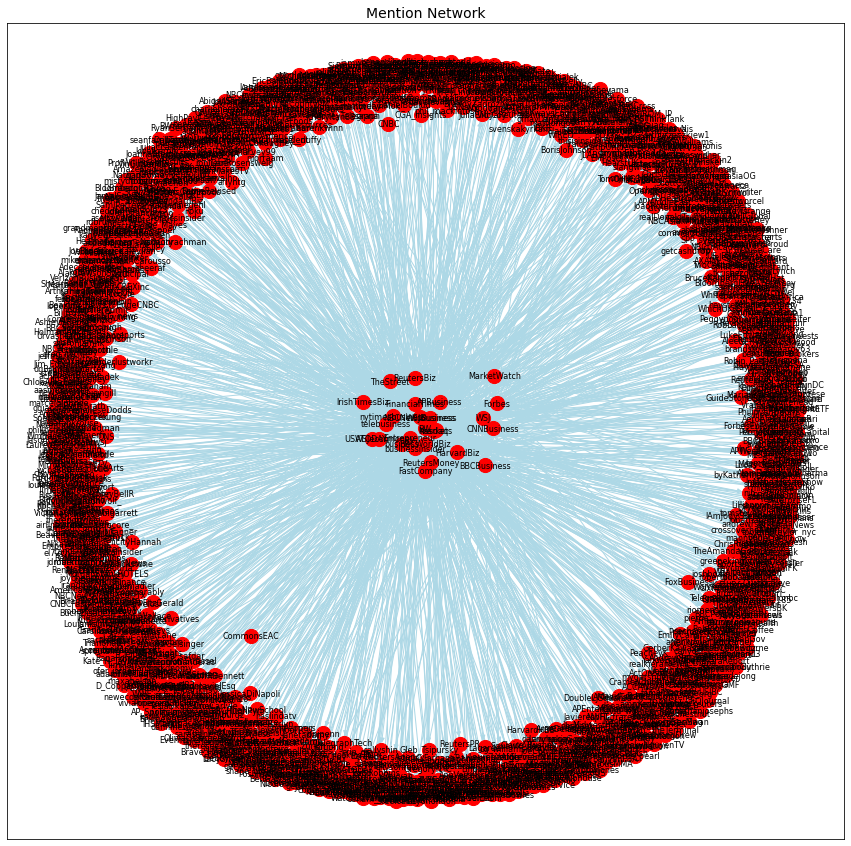

In [33]:
makeGraph(mentionNetwork, "red", "Mention Network")

### ADD EDGE Weights

## User Hashtag Network

In [34]:
userGraph = pd.DataFrame(tweets).set_index("id")

In [35]:
columns = ["user", "entities"]

In [36]:
userGraph.drop(userGraph.columns.difference(columns), 1, inplace=True)

In [37]:
userHash = pd.json_normalize(userGraph["entities"])

In [38]:
userHash1 = pd.json_normalize(userGraph["user"])

In [39]:
columnsNeeded = ['hashtags']

In [40]:
userHash.drop(userHash.columns.difference(columnsNeeded), 1, inplace=True)

In [41]:
userHash1

,id,id_str,name,screen_name,location,description,url,protected,followers_count,friends_count,...,profile_use_background_image,has_extended_profile,default_profile,default_profile_image,following,follow_request_sent,notifications,translator_type,entities.url.urls,entities.description.urls
0,3108351,3108351,The Wall Street Journal,WSJ,"New York, NY",Sign up for our newsletters and email alerts: ...,https://t.co/GhhR6PLfem,False,18452260,1003,...,False,False,False,False,False,False,False,regular,"[{'url': 'https://t.co/GhhR6PLfem', 'expanded_...","[{'url': 'https://t.co/WFU7oLKkip', 'expanded_..."
1,14800270,14800270,Harvard Business Review,HarvardBiz,,The best ideas in business and management to h...,http://t.co/FXkjfGSn3I,False,5663760,217,...,False,False,False,False,False,False,False,none,"[{'url': 'http://t.co/FXkjfGSn3I', 'expanded_u...",[]
2,11014272,11014272,Finance News,ftfinancenews,,The latest news and analysis on the finance in...,http://t.co/XpTSOKSsTI,False,639370,24,...,True,False,False,False,False,False,False,none,"[{'url': 'http://t.co/XpTSOKSsTI', 'expanded_u...",[]
3,3108351,3108351,The Wall Street Journal,WSJ,"New York, NY",Sign up for our newsletters and email alerts: ...,https://t.co/GhhR6PLfem,False,18452261,1003,...,False,False,False,False,False,False,False,regular,"[{'url': 'https://t.co/GhhR6PLfem', 'expanded_...","[{'url': 'https://t.co/WFU7oLKkip', 'expanded_..."
4,1754641,1754641,NYT Business,nytimesbusiness,"New York, NY","Financial, tech, media and other business news...",http://t.co/OKrfdBy4ch,False,824924,446,...,True,False,False,False,False,False,False,none,"[{'url': 'http://t.co/OKrfdBy4ch', 'expanded_u...",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,67358777,67358777,Businessweek,BW,"Homes, screens, and stores",Covering the business world like no one else. ...,https://t.co/qrSeHX6o20,False,1787449,575,...,True,False,False,False,False,False,False,none,"[{'url': 'https://t.co/qrSeHX6o20', 'expanded_...","[{'url': 'https://t.co/gog4OAefj7', 'expanded_..."
15996,11014272,11014272,Finance News,ftfinancenews,,The latest news and analysis on the finance in...,http://t.co/XpTSOKSsTI,False,639370,24,...,True,False,False,False,False,False,False,none,"[{'url': 'http://t.co/XpTSOKSsTI', 'expanded_u...",[]
15997,95213382,95213382,Independent Business,IndoBusiness,Dublin,The Business and Technology feed from the @ind...,http://t.co/AShy0RzV6b,False,15185,64,...,True,False,True,False,False,False,False,none,"[{'url': 'http://t.co/AShy0RzV6b', 'expanded_u...",[]
15998,624413,624413,MarketWatch,MarketWatch,"New York, NY","News, personal finance & commentary from Marke...",http://t.co/0HcV671qZB,False,3854902,200,...,True,False,False,False,False,False,False,none,"[{'url': 'http://t.co/0HcV671qZB', 'expanded_u...",[]


In [42]:
columnsNeeded = ['name']

In [43]:
userHash1.drop(userHash1.columns.difference(columnsNeeded), 1, inplace=True)

In [44]:
userHash1

,name
0,The Wall Street Journal
1,Harvard Business Review
2,Finance News
3,The Wall Street Journal
4,NYT Business
...,...
15995,Businessweek
15996,Finance News
15997,Independent Business
15998,MarketWatch


In [45]:
userHashtag = pd.concat([userHash1.reset_index(drop=True),userHash.reset_index(drop=True)], axis=1)

In [46]:
userHashtag

,name,hashtags
0,The Wall Street Journal,[]
1,Harvard Business Review,[]
2,Finance News,[]
3,The Wall Street Journal,[]
4,NYT Business,[]
...,...,...
15995,Businessweek,[]
15996,Finance News,[]
15997,Independent Business,[]
15998,MarketWatch,[]


In [47]:
userHashtag = userHashtag[userHashtag['hashtags'].map(lambda drop: len(drop)) > 0]
userHashtag

,name,hashtags
55,Reuters Money,"[{'text': 'AppleEvent', 'indices': [53, 64]}]"
108,Independent Business,"[{'text': 'sponsored', 'indices': [55, 65]}]"
127,BBC Business,"[{'text': 'Millionby30', 'indices': [137, 149]}]"
135,BBC World Business,"[{'text': 'Automotive', 'indices': [35, 46]}]"
160,Forbes,"[{'text': 'DecadeofU30', 'indices': [138, 150]}]"
...,...,...
15838,Bloomberg Markets,"[{'text': 'crypto', 'indices': [17, 24]}, {'te..."
15840,BBC Business,"[{'text': 'NYE', 'indices': [33, 37]}]"
15868,Reuters Money,"[{'text': 'REIT', 'indices': [106, 111]}, {'te..."
15902,BBC Business,"[{'text': 'WorldBusinessReport', 'indices': [1..."


In [48]:
pairs = []
for i, row in userHashtag.iterrows():
    for j in range(len(row['hashtags'])):
            pairs.append((row['name'], row['hashtags'][j]['text']))

In [51]:
# Create the bipartite network
hashNetwork = nx.Graph()
userNodes, hashNodes = set(), set()
for p in pairs:
    username = p[0],
    hashtag = p[1]    
    # create the nodes, users and hashtags
    if not username in userNodes:
        hashNetwork.add_node(username, bipartite=0)
        userNodes.add(username)
    if not hashtag in hashNodes:
        hashNetwork.add_node(hashtag, bipartite=1)
        hashNodes.add(hashtag)    
    # create the edge 
    hashNodes.add(hashtag)
    hashNetwork.add_edge( username, hashtag )
print("Created bipartite network with %d nodes and %d edges" % ( hashNetwork.number_of_nodes(), hashNetwork.number_of_edges() ) )

Created bipartite network with 299 nodes and 315 edges


In [52]:
bipartite.is_bipartite(hashNetwork)

True

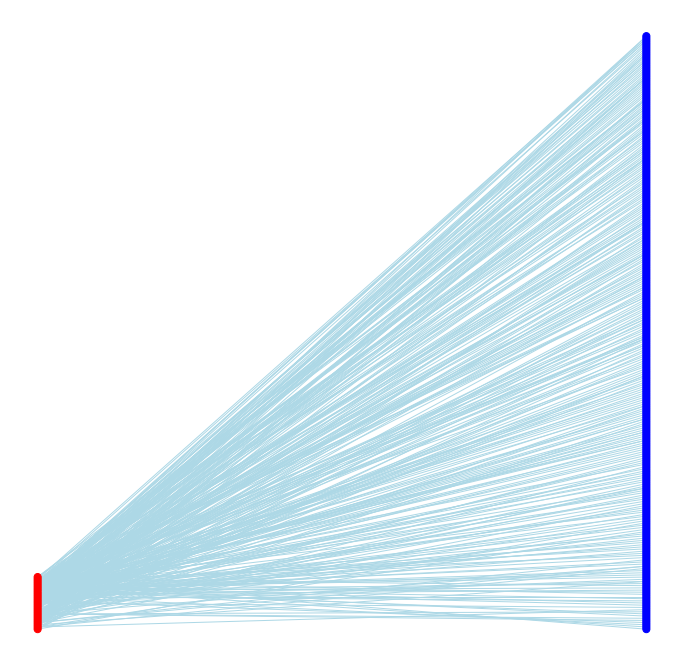

In [56]:
# manually set the node colours and positions
color_map, pos = {}, {}
for i, node in enumerate(userNodes):
    pos[node] = (0, i*10)
    color_map[node] = "red"
for i, node in enumerate(hashNodes):
    pos[node] = (1, i*10)
    color_map[node] = "blue"
colors = [color_map[node] for node in hashNetwork.nodes()]
# draw the network    
plt.figure(figsize=(12,12))
nx.draw_networkx(hashNetwork, pos=pos, with_labels=False, 
        node_size = 50,
        font_size = 9,
        node_color = colors, edge_color = "lightblue")
plt.axis("off")
plt.show()

## Hashtag co-occurrence network

In [57]:
usernames = []
for i, row in userHashtag.iterrows():
        usernames.append(row['name'])

In [58]:
hashtagStore = {}
for x in usernames:
    hashtagStore[x] = []
for p in pairs:
    hashtagStore[p[0]].append( p[1] )

In [59]:
pair_counts = Counter()
for h in hashtagStore:
    # use itertools to find all unique combinations
    hPairs = list( itertools.combinations(hashtagStore[h], r=2) )
    # update the pair counts
    for pair in hPairs:
        pair_counts[pair] += 1

In [60]:
coNet = nx.Graph()
for pair in pair_counts:
    coNet.add_edge( pair[0], pair[1], weight=pair_counts[pair] )
coNet.number_of_nodes(), coNet.number_of_edges()

(273, 4300)

In [61]:
df = nx.to_pandas_edgelist(coNet)
df.sort_values(by="weight",ascending=False).head(20)

,source,target,weight
2648,SmartInvesting,SmartInvesting,1653
2469,NasdaqListed,SmartInvesting,1623
2471,NasdaqListed,NasdaqListed,1485
893,COVID19,SmartInvesting,1286
889,COVID19,NasdaqListed,1196
840,COVID19,COVID19,1183
3793,WSJWhatsNow,WSJWhatsNow,1035
161,AskReuters,AskReuters,630
2468,NasdaqListed,GreenVoices,546
2604,GreenVoices,SmartInvesting,477


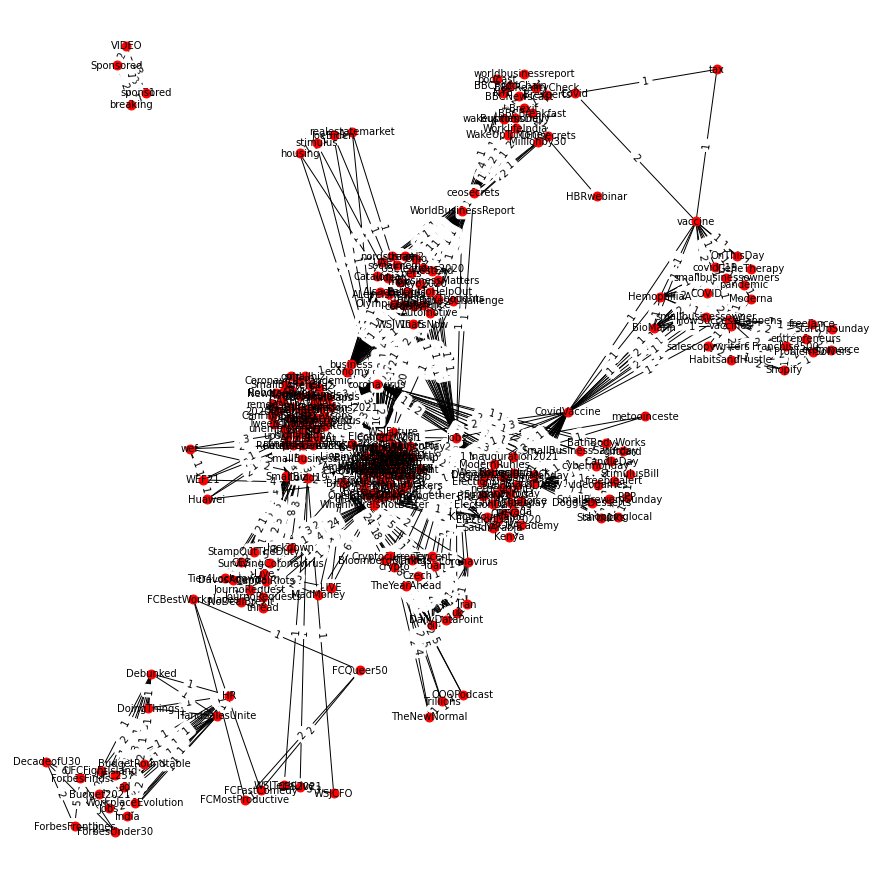

In [63]:
plt.figure( figsize=(12,12) ) 
# apply layout algorithm to calculate node positions
pos = nx.spring_layout(coNet, k=0.3 )
# draw the nodes and edges
nx.draw(coNet, pos, with_labels = True, node_size=80, font_size=10, font_color="black", node_color="red")
# now add the edge weights as labels
labels = nx.get_edge_attributes(coNet, 'weight')
nx.draw_networkx_edge_labels(coNet, pos,edge_labels=labels);